## <font color=darkblue> Gradient descent for Optimization and Machine Learning </font>


In this notebook, we provide an **overview of gradient-based optimization algorithms** with a specific **focus on first order methods and accelerated algorithms** which are commonly used in machine/deep learning. Supervised learning applications are usually based on the minimization of an objective function on $\mathbb{R}^d$ (kernel based SVM models, penalized regression, maximum likelihood estimation of neural networks) and accelerated gradient methods are the go-to solutions to solve these optimization problems.

The results provided in this notebook are valid with assumptions on the target functions such as convexity or strong convexity (some of them may be relaxed). Although these algorithms are widely used, keep in mind that these assumptions do not hold in practice and that  non-convexity stems from the arbitrary form of the loss functions used in machine learning.

This will motivate **additional sessions on alternative methods such as evolutionary approaches for difficult non-linear non-convex optimisation problems** in continuous and discrete domains (for instance the CMA-ES algorithm).

### <font color=darkred> Bibliography & additional ressources </font>

- [1] Convex Optimization, S. Boyd & L. Vandenberghe, 2009, https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf
``Very complete book on convex optimization and gradient descent algorithms (full gradient, Newton's method, constrained problems)``
, etc.
- [2] Convex Optimization: Algorithms and
Complexity, S. Bubeck, 2015, https://arxiv.org/pdf/1405.4980.pdf

-  [3] Probabilistic machine learning: an introduction, Kevin P. Murphy, 2022, https://probml.github.io/pml-book/book1.html
``Full book online with all basics on machine learning. Not state-of-the-art but very good introduction``

- [4] Learning theory from first principles, F. Bach, 2023, https://www.di.ens.fr/~fbach/ltfp_book.pdf
``Much more advanced reference, Chapter 5 on optimization``

- [5] Algorithms for optimization, M. J. Kochenderfer and T. A. Wheeler, 2019.


### <font color=darkred>Introduction : general framework & motivations</font>

Parameter inference in machine learning often boils down to solving

\begin{equation*}
\mathrm{argmin}_{w \in \mathbb{R}^d} \,\{f(w) + \lambda \mathrm{pen}(w)\}\,,
\end{equation*}

with $\lambda>0$, $\mathrm{pen}(\cdot)$ some penalization function and $f$ a ``goodness-of-fit function``  based on a loss $\ell$,

\begin{equation*}
f(w) = \frac 1n \sum_{i=1}^n \ell(y_i, \langle w, x_i \rangle)\,,
\end{equation*}

 where $(x_i,y_i)_{1\leq i\leq n}$ are ``training examples of inputs and outputs`` (in a supervised setting), and $w$ is an ``unknown parameter to be estimated.``


**Examples of penalization functions**:

- $\mathrm{pen}(w) =  \|w\|_2^2$ (Ridge for regularization).

- $\mathrm{pen}(w) = \|w\|_1$ (Lasso for sparsity),
see Tibshirani, R. (1996). 
``Regression shrinkage and selection via the lasso. Journal of the Royal Statistical Society: Series B (Methodological), 58(1), 267–288, and all extensions``


**First order necessary condition**
		
Let $f : \mathbb{R} \to \mathbb{R}$ be a differentiable function. If $x^{\star}$ is a local extremum (minimum/maximum) then $f'(x^{\star}) = 0$.
		
Illustration from [4]. For **convex functions, we only need to look for stationary points**. This is
not the case for potentially non-convex functions. For example, in one dimension below, all
red points are stationary points that are not the global minimum (which is in green).



![](https://drive.google.com/uc?export=view&id=1dB0TjQVALJeEVglIXDV-Bz6ZdLYT1avD)
	
**Generalization for $d>1$**
		
Let $f: \mathbb{R}^d \to \mathbb{R}$ be a differentiable function. If $x^{\star}$ is a local extremum then $\nabla f(x^{\star}) = 0$. Points such that $\nabla f(x^{\star}) = 0$ are called critical points. Critical points are not always extrema (consider $x \mapsto x^3$).


*Some useful gradients*

- If $f: \mathbb{R} \to \mathbb{R}$, $\nabla f(x) = f'(x)$.

- $f:x \mapsto \langle a,x\rangle$: $\nabla f(x) = a$.
	
- $f:x \mapsto x^T A x$: $\nabla f(x) = (A + A^T) x$.
	
- Particular case: $f: x \mapsto \|x\|^2$, $\nabla f(x) = 2x$.


**Heuristic: why gradient descent works?**
	
For a function $f: \mathbb{R}^d \to \mathbb{R}$, define the level sets: 
$$
\mathcal{C}_c = \{ x \in \mathbb{R}^d, f(x) = c\}\,.
$$
In red, level sets and in blue value of the gradient.	
![](https://drive.google.com/uc?export=view&id=15lbus29MvZRBplJyY6D2CE3pVJKCvvp_)
	
The gradient is orthogonal to level sets. 

### <font color=darkred>Introduction : a test function -  logistic regression</font>

- The objective is to predict the  label $Y\in\{0,1\}$ based on $X\in\mathbb{R}^d$.

- Logistic regression models the distribution of $Y$ given $X$.

\begin{equation*}
\mathbb{P}_w(Y = 1| X) = \sigma(\langle w,X \rangle )\,,
\end{equation*}
where $w \in \mathbb{R}^d$ is a vector of model weights, and where $\sigma$ is the sigmoid function. 

$$
\sigma: z \mapsto \frac{1}{1 + e^{-z}}\,.
$$

- The sigmoid function is a model choice to map $\mathbb{R}$ into $(0,1)$.

In [ ]:
import numpy as np
import scipy
import pandas as pd
import autograd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=2)
plt.rcParams.update(
    {
        "font.size": 25,
        "figure.figsize": (14, 7),
        "axes.grid": True,
        "grid.color": "#93a1a1",
        "grid.alpha": 0.3,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)

In [ ]:
def sigmoid(x):
    exp_x = np.exp(x)
    return exp_x / (1 + exp_x)

def sample_logistic(w0, n_samples=1000, corr=0.5):
    n_features = w0.shape[0]
    cov = scipy.linalg.toeplitz(corr ** np.arange(0, n_features))
    X = np.random.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(X.dot(w0))
    y = np.random.binomial(1, p, size=n_samples)
    return X, y

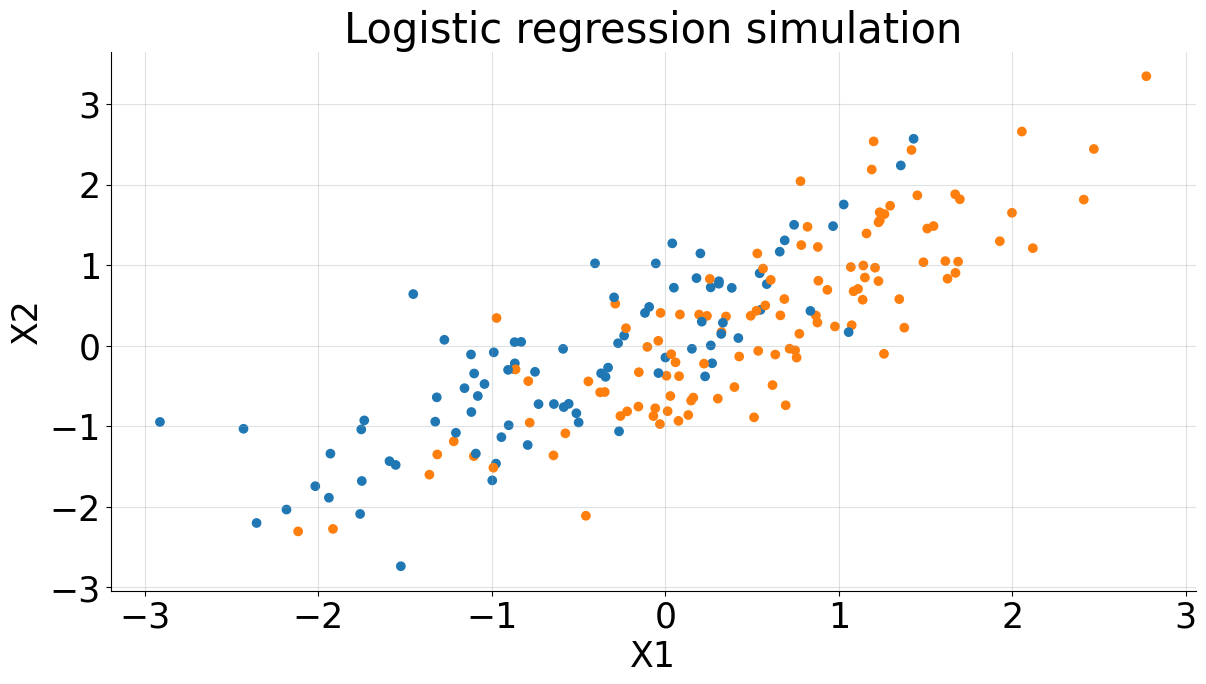

In [ ]:
n_samples = 200
n_features = 2
# Generate the dataset
w0 = np.random.multivariate_normal([-3,1], np.eye(2))
X, y = sample_logistic(w0, n_samples=n_samples, corr=0.8)
simulated_data = pd.DataFrame.from_dict({
    "x1": X[:, 0],
    "x2": X[:, 1],
    "Label": y
})
# Plot the dataset
simulated_data["colors"] = simulated_data["Label"].apply(lambda label: "C0" if label == 1 else "C1")
plt.xlabel("X1")
plt.ylabel("X2")
plt.scatter(*X.T, c=simulated_data["colors"])
plt.title("Logistic regression simulation");

##### <font color=darkred>  Logistic regression: losses and gradients </font>

The aim of this section is to detail how to solve the following optimization problem
$$
\arg\min_{w \in \mathbb{R}^d} \Big\{ L(w) = f(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}\,,
$$
where $d$ is the number of features. The function **$f$ is the opposite of the normalized loglikelihood of the observations**. Therefore,
$$
f:w\mapsto -\frac{1}{n}\log \mathbb{P}_w(Y_{1:n} = y_{1:n}|X_{1:n}) = -\frac{1}{n}\sum_{i=1}^n\log \mathbb{P}_w(Y_{i}=y_i|X_{i})\,,
$$
which yields
$$
L: w \mapsto  \frac{1}{n} \sum_{i=1}^n \{-y_ix_i^\top w + \log(1 + \exp(x_i^\top w))\} + \frac{\lambda}{2} \|w\|_2^2\,,
$$
where $n$ is the sample size, and where $y_i \in \{ 0, 1 \}$ for all $1\leqslant i\leqslant n$.
 
An elementary gradient descent algorithm requires to compute the functions $L$ and $\nabla L$, where

$$
\nabla L: w \mapsto \frac{1}{n} \sum_{i=1}^n (\sigma(w^\top x_i)-y_i)x_i + \lambda w\,.
$$


In [ ]:
class LogisticRegression:
    def __init__(self, X, y, lambd):
        self.X = X
        self.y = y
        self.lambd = lambd
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        # Computes f(w)
        res = sum([
            np.log(1 + np.exp(observation @ w)) - label * observation @ w
            for observation, label in zip(self.X, self.y)
        ]) / self.n_samples
        res += self.lambd*0.5*(np.linalg.norm(w)**2)
        return res
    
    def grad(self, w):
        # Computes the gradient of f at w
        res = sum([
            -label * observation + np.exp(observation @ w) / (1 + np.exp(observation @ w)) * observation
            for observation, label in zip(self.X, self.y)
        ]) / self.n_samples
        res += self.lambd * w
        return res  
    
    def grad_fi(self, i, w):
        # Computes the gradient of f_i at w
        return -y[i] * self.X[i] + np.exp(self.X[i] @ w) / (1 + np.exp(self.X[i] @ w)) * self.X[i] + self.lambd * w

    def grad_coordinate(self, j, w):
        # Computes the partial derivative of f with respect to the j-th coordinate 
        res = sum([
            -label * observation[j] + np.exp(observation @ w) / (1 + np.exp(observation @ w)) * observation[j]
            for observation, label in zip(self.X, self.y)
        ]) / self.n_samples
        res += self.lambd * w[j]
        return res

In [ ]:
# Check numerically the gradient using the function checkgrad from scipy.optimize
# Use the function sample_logistic to simulate data according to the logistic regression model
n_features = 10
w_true = np.random.randn(n_features)
X, y = sample_logistic(w_true, n_samples, corr=0.9)
model = LogisticRegression(X, y, 1e-3)
# check_grad assesses the correctness of a gradient by comparing it to a finite-difference approximation
scipy.optimize.check_grad(model.loss, model.grad, w_true)

4.900589171578982e-08

### <font color=darkred> Part I : First order approaches </font>

The most simple method  is based on **full gradients**, since at each iteration  it requires to compute
$$
\nabla f(w) = \frac 1n \sum_{i=1}^n \nabla  f_i(w)\,,
$$
which depends on the **whole dataset**. When processing very large datasets ($n$ is large), this approach has a highly prohibitive computational cost  for a  unique step towards the minimum. 
For all $k\geqslant 1$, set
$$
w^{(k)} = w^{(k-1)} - \eta_k \nabla f_{}(w^{(k-1)})\,.
$$
Each iteration has complexity $O(nd)$.

##### <font color=darkred> Full gradient descent </font>

- ``Input``: Function $f$ to minimize, initial vector $w^{(0)}$, $k=0$.

- Parameters: step size $\eta_k>0$, $k\geq 1$.
	
While not converge do

- $w^{(k+1)} = w^{(k)} - \eta_{k+1} \nabla f(w^{(k)})$.

- $k = k+1$.

- ``Output``: $w^{(n_*)}$ where $n_*$ is the last iteration.

###### **Implementation from scratch**

In [ ]:
def gradient_descent(model, w0, iterations, step_size):
    loss_history = []
    w = w0.copy()
    for k in range(iterations):
        #### 
        # A completer
        w = w - step_size * model.grad(w)
        loss_history.append(model.loss(w))
        ####
    return w, loss_history

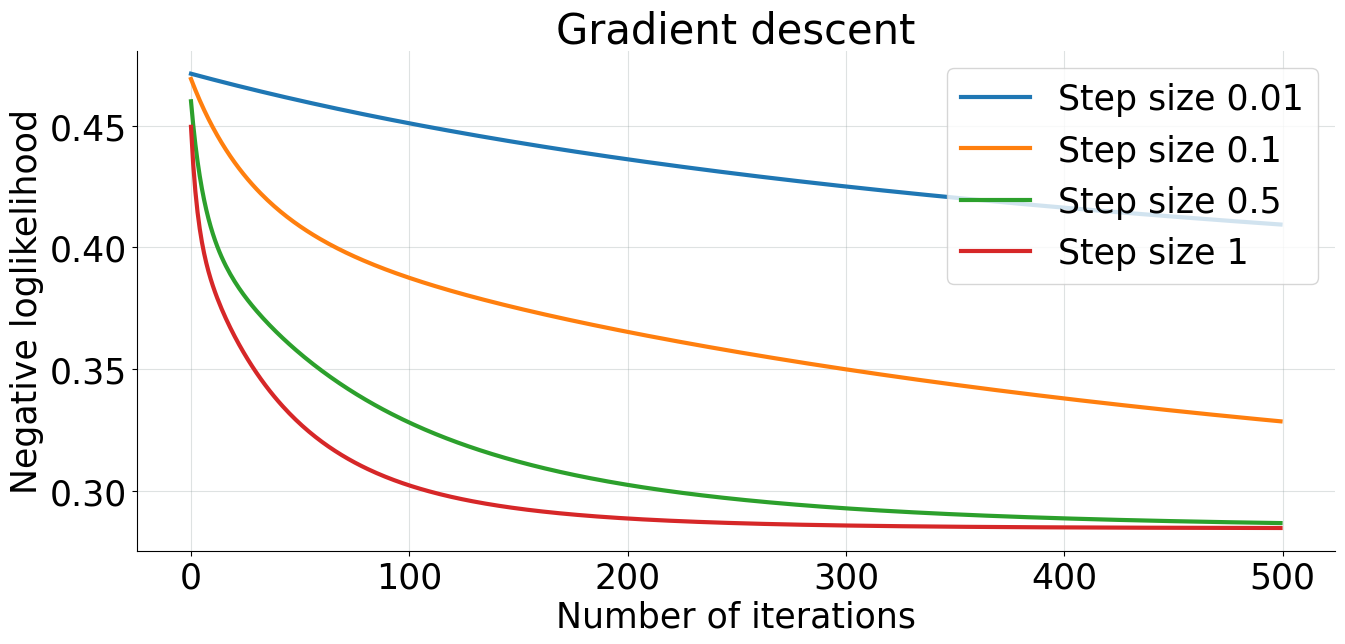

In [ ]:
# We compare the following step sizes
compared_step_sizes = [1e-2, 1e-1, 5e-1 ,1]
# Weights are initialized once at random
w0 = np.random.randn(n_features)
iterations = 500
for step_size in compared_step_sizes:
    _, loss_history = gradient_descent(model, w0, iterations, step_size)
    plt.plot(loss_history, '-', lw=3, label=f"Step size {step_size}")
# Configure plot
plt.title('Gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('Negative loglikelihood')
plt.tight_layout()
plt.legend();

###### **Implementation with torch**

In [ ]:
class LogisticRegressionTorch(LogisticRegression):
    def __init__(self, X, y, lambd):
        # Start with the same initialization
        super().__init__(X, y, lambd)
        # Convert dataset to tensors
        self.X = torch.tensor(self.X)
        self.y = torch.tensor(self.y).unsqueeze(-1).double()
        # Define the layer for the dot product
        self.layer = torch.nn.Linear(self.n_features, 1, bias=False)
        # Define the gradient descent optimizer
        self.optimizer = torch.optim.SGD(self.layer.parameters(), lr=1e-1)
    
    def loss(self, w):
        # Set the parameters of the layer to the input ``w``
        self.layer.weight.data = torch.tensor(w).unsqueeze(0)
        # Compute the regularized cross entropy loss
        return F.binary_cross_entropy(
            F.sigmoid(self.layer(self.X)), 
            self.y
        ) + torch.norm(self.layer.weight).square() * self.lambd / 2
    
    def grad(self, w):
        # Reset the gradient attached to ``w``
        # By default, torch adds up new gradient computations, unlike tensorflow or mxnet
        self.layer.zero_grad()
        self.loss(w).backward()
        return self.layer.weight.grad
    
    def gradient_descent(self, w, iterations, step_size):
        # Set the parameters of the layer to the input ``w``
        self.layer.weight.data = torch.tensor(w).unsqueeze(0)
        optimizer = torch.optim.SGD(self.layer.parameters(), lr=step_size)
        hist = []
        for _ in range(iterations):
            # Reset the gradient attached to ``w``
            # By default, torch adds up new gradient computations, unlike tensorflow or mxnet
            optimizer.zero_grad()
            # Compute the regularized cross entropy loss
            loss = F.binary_cross_entropy(
                F.sigmoid(self.layer(self.X)), 
                self.y
            ) + torch.norm(self.layer.weight).square() * self.lambd / 2
            # Compute the gradient of the loss with respect to the input ``w``
            loss.backward()
            # Take on gradient step
            optimizer.step()
            # Log the initial loss value
            hist.append(loss.item())
        return self.layer.weight.data.detach().numpy(), hist

In [ ]:
model_torch = LogisticRegressionTorch(X, y, lambd=1e-3)

print("Loss for w0:")
print("\tHandmade model:\t", model.loss(w0))
print("\tTorch model:\t", model_torch.loss(w0).item())
print("Gradient of w0:")
print("\tHandmade model:\t", model.grad(w0))
print("\tTorch model:\t", model_torch.grad(w0).numpy().squeeze())

Loss for w0:
	Handmade model:	 0.471586066359731
	Torch model:	 0.4715860663597312
Gradient of w0:
	Handmade model:	 [-0.06 -0.08 -0.08 -0.03  0.01 -0.02  0.    0.03  0.05  0.05]
	Torch model:	 [-0.06 -0.08 -0.08 -0.03  0.01 -0.02  0.    0.03  0.05  0.05]


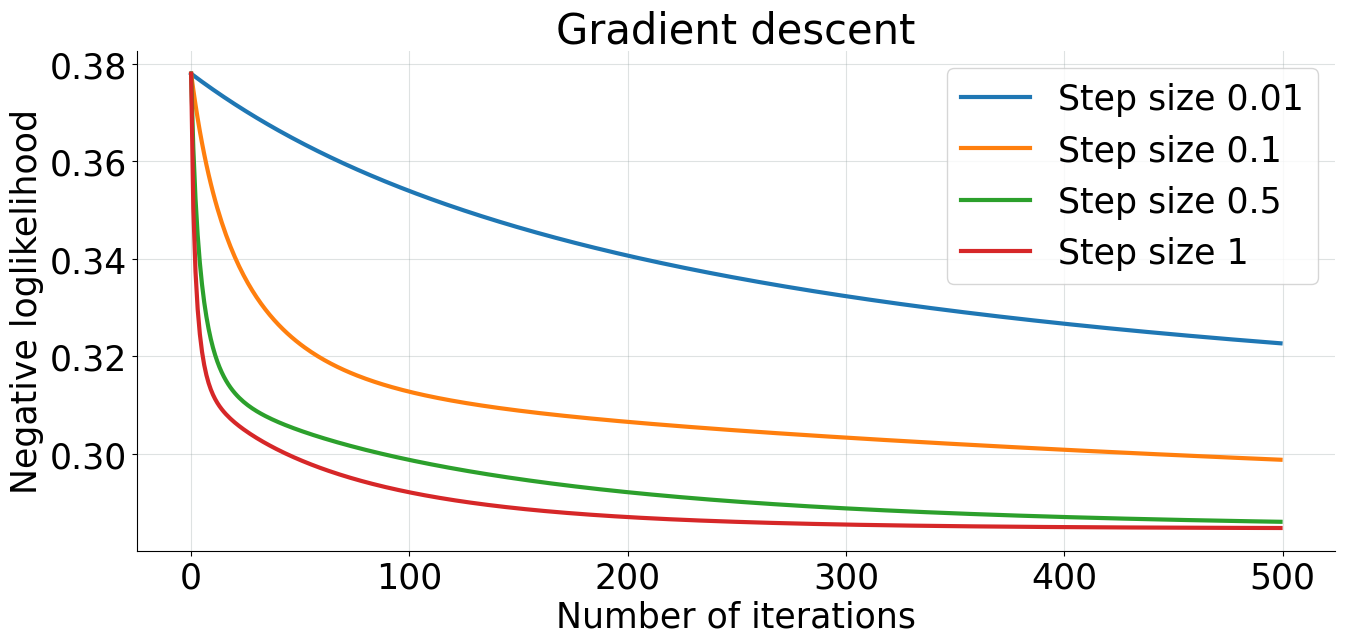

In [ ]:
# We compare the following step sizes
compared_step_sizes = [1e-2, 1e-1, 5e-1 ,1]
# Weights are initialized once at random
w0 = np.random.randn(n_features)
iterations = 500
for step_size in compared_step_sizes:
    _, loss_history = model_torch.gradient_descent(w0, iterations, step_size)
    plt.plot(loss_history, '-', lw=3, label=f"Step size {step_size}")
# Configure plot
plt.title('Gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('Negative loglikelihood')
plt.tight_layout()
plt.legend();

###### **Convergence**

``Convex function``

A function $f : \mathbb{R}^d \to \mathbb{R}$ is convex on $\mathbb{R}^d$ if, for all $x, y \in \mathbb{R}^d$, for all $\lambda \in [0,1]$,
$$
f(\lambda x + (1- \lambda) y ) \leq \lambda f(x) + (1 - \lambda) f(y).
$$	
Illustration of a convex function from [1].
![](https://drive.google.com/uc?export=view&id=17AZASkc-y_ZH-MDGPgmqDkuVfnYKU6-k)


Illustration of a strongly convex function from [4].
![](https://drive.google.com/uc?export=view&id=1tRnGMLa6Yw1vGUl8EnxBLTg_VEN9ay7T)

``$L$-smooth function``

A function $f$ is said to be $L$-smooth if $f$ is differentiable and if, for all $x, y \in \mathbb{R}^d$, 
$$
\| \nabla f(x) - \nabla f(y) \| \leqslant L \|x-y\|\,.
$$
	
If $f$ is twice differentiable, this is equivalent to writing that for all $x \in \mathbb{R}^d$,  
	
$$
\lambda_{max} (\nabla^2 f(x)) \leqslant L,
$$
where $\lambda_{max}(A)$ is the largest eigenvalue of a matrix $A$.


Let $f : \mathbb{R}^d \to \mathbb{R}$ be a $L$-smooth convex function. Let $w^{\star}$ be a minimum of $f$ on $\mathbb{R}^d$. Then, Gradient Descent with step size $\eta \leqslant 1/L$ satisfies

\begin{align*}
f(w^{(k)}) - f(w^{\star}) \leqslant \frac{\|w^{(0)} - w^{\star}\|_2^2}{2 \eta k}\,.
\end{align*}

**Remark**

Consider a quadratic convex functions, i.e. a function $f$ such that  $f: w\mapsto w^\top Hw/2 - c^\top w$ with $c\in\mathbb{R}$ and $H$ a symmetric positive definite matrix in $\mathbb{R}^{d\times d}$. In this case, $f$ is $\mu$-strongly convex and $L$- smooth with $\mu$ (resp. $L$) the smallest (resp. largest) eigenvalues of $H$. As for all $w\in\mathbb{R}^d$, $\nabla f(w) = Hw -c$, the unique minimum of $f$ is $w^\star = H^{-1}c$ and for all $k\geqslant 1$,
$$
w^{(k+1)} = w^{(k)} - \eta_{k+1}\left(Hw^{(k)}-c\right) = w^{(k)} - \eta_{k+1} H\left(w^{(k)}-w^\star\right)\,,
$$
which yields
$$
w^{(k+1)}- w^\star = \left(I_d - \eta_{k+1} H\right)\left(x^{(k)}-w^\star\right) = \left(I_d - \eta H\right)^k\left(w^{(1)}-w^\star\right)\,,
$$
when for all $k\geq 1$, $\eta_k = \eta$.

##### <font color=darkred> Stochastic gradient descent </font>

Previous methods are based on full gradients, since each iteration requires the computation of
	\begin{equation*}
		\quad \nabla f(w) = \frac 1n \sum_{i=1}^n \nabla  f_i(w),
	\end{equation*}
	which depends on the **whole dataset**
	. 
  
  If $n$ is large, computing $\nabla f(w)$ is computationally expensive. If $I$ is  chosen uniformly at random in $\{ 1, \ldots, n \}$, then

\begin{align*}
\mathbb{E}[ \nabla f_I(w) ] =
\frac 1n \sum_{i=1}^n \nabla f_{i}(w) = \nabla f(w)\,,
\end{align*}

**$\nabla f_I(w)$ is an unbiased but very noisy estimate of the full gradient $\nabla f(w)$**.

Computation of $\nabla f_I(w)$ only requires the $I$-th observation.

``Input``: starting point $w^{(0)}$, steps (learning rates) $\eta_k$

`- For $k = 1, 2, \ldots$ until convergence do

- Pick at random (uniformly) $I_k$ in $\{ 1, \ldots, n \}$.

- Compute
\begin{equation*}
w^{(k)} = w^{(k-1)} - \eta_k \nabla f_{I_k}(w^{(k-1)})\,.
\end{equation*}

``Output``:  last $w^{(n_*)}$.



Each iteration has complexity $O(d)$ instead of
$O(nd)$ for full gradient methods.

Of course, a best trade-off (estimator of the full gradient with a lower variance than using only one observation but still at a better cost than a full gradient update) is obtained by **using a batch of observations at each time step**.


###### **Implementation from scratch**

In [ ]:
def sgd(model, w0, iterations, step_size, alpha):
    loss_val  = np.zeros(iterations)
    w = w0.copy()
    n_samples = model.n_samples
    for idx in range(iterations):
        ####
        # A completer
        i = np.random.randint(0, model.n_samples)
        w = w - step_size * model.grad_fi(i,w) / ((idx+1)**alpha)
        loss_val[idx] = model.loss(w)
        ####
    return w, loss_val

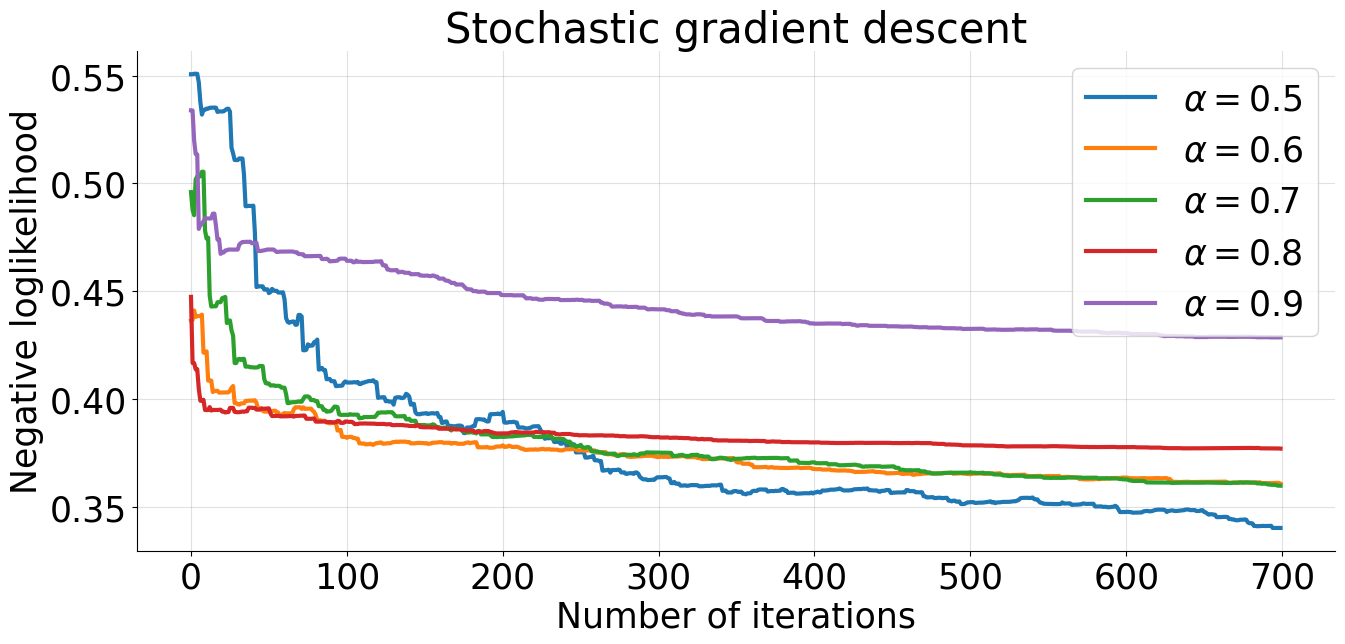

In [ ]:
# We compare the following values for alpha
compared_alphas = [0.5, 0.6, 0.7, 0.8, 0.9]
# Weights are initialized once at random
w0 = np.random.randn(n_features)
step_size = 0.5
iterations = 700
for alpha in compared_alphas:
    _, loss_history = sgd(model, w0, iterations, step_size, alpha)
    plt.plot(loss_history, '-', lw=3, label=f"$\\alpha={alpha}$")
# Configure plot
plt.title('Stochastic gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('Negative loglikelihood')
plt.tight_layout()
plt.legend();

###### **Implementation with torch**

In [ ]:
class LogisticRegressionTorch(LogisticRegression):
    def __init__(self, X, y, lambd):
        super().__init__(X, y, lambd)
        self.X = torch.tensor(self.X)
        self.y = torch.tensor(self.y).unsqueeze(-1).double()
        self.layer = torch.nn.Linear(self.n_features, 1, bias=False)

    # We now consider the loss as a function of observations and labels
    # This is the torch way
    def loss(self, X, y):
        return F.binary_cross_entropy(
            F.sigmoid(self.layer(X)), 
            y
        ) + torch.norm(self.layer.weight).square() * self.lambd
    
    def sgd(self, w, iterations, lr, alpha):
        # In practice, weights are directly initialized by the layer
        # And we don't manually set its value
        self.layer.weight.data = torch.tensor(w).unsqueeze(0)
        optimizer = torch.optim.SGD(self.layer.parameters(), lr=lr)
        hist = []
        for idx in range(iterations):
            # Reset gradient
            optimizer.zero_grad()
            # Select a random sample in the dataset
            i = np.random.randint(0, self.n_samples)
            # Compute the loss and the gradient for this sample
            self.loss(self.X[i:i+1], self.y[i:i+1]).backward()
            self.layer.weight.grad /= ((idx+1)**alpha)
            # Update the parameters w
            optimizer.step()
            # Log the loss on the full dataset
            hist.append(self.loss(self.X, self.y).item())
        return w, hist
model_torch = LogisticRegressionTorch(X, y, lambd=1e-3)

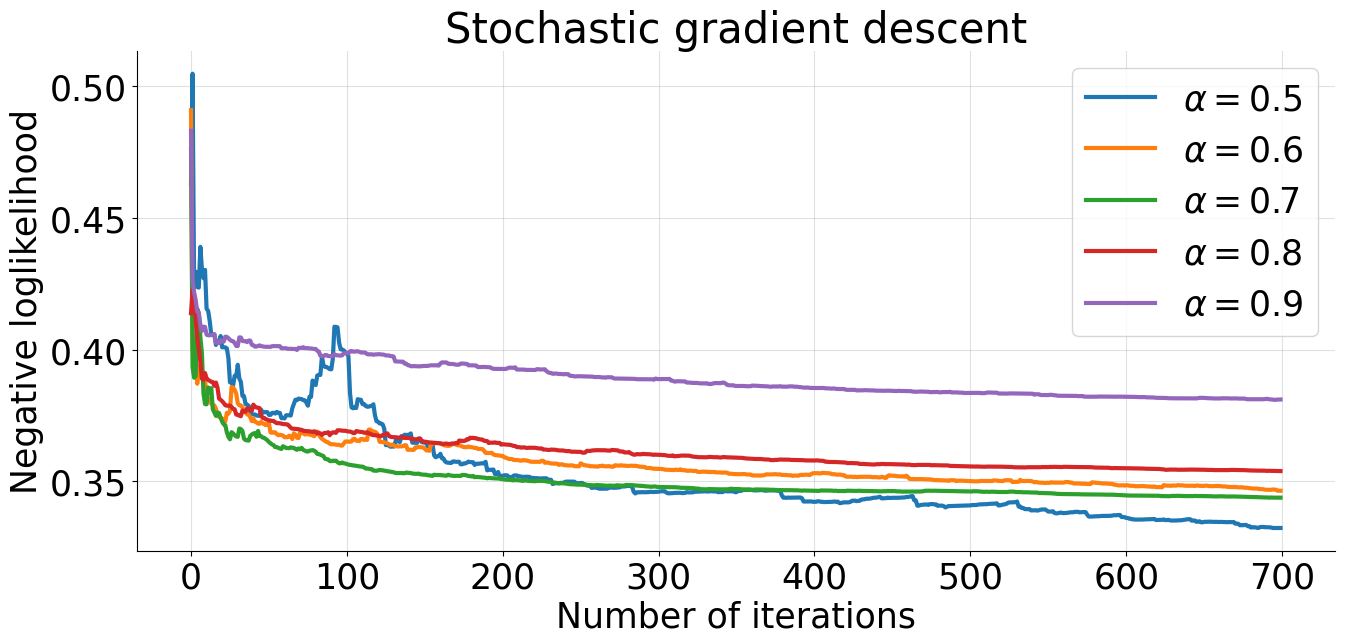

In [ ]:
# We compare the following values for alpha
compared_alphas = [0.5, 0.6, 0.7, 0.8, 0.9]
# Weights are initialized once at random
w0 = np.random.randn(n_features)
step_size = 0.5
iterations = 700
for alpha in compared_alphas:
    _, loss_history = model_torch.sgd(w0, iterations, lr=step_size, alpha=alpha)
    plt.plot(loss_history, '-', lw=3, label=f"$\\alpha={alpha}$")
# Configure plot
plt.title('Stochastic gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('Negative loglikelihood')
plt.tight_layout()
plt.legend();

###### **Convergence**

Project each estimate into the ball $B(0,R)$ with $R>0$ fixed. 
	
Let 
$$
f (x) = \frac{1}{n} \sum_{i=1}^n f_i(x)\,.
$$
	

Assume that $f$ is convex and that there exists $b>0$ satisfying, for all $x \in B(0,R)$, 
$$
\|\nabla f_i (x)\| \leqslant b\,.
$$		

Assume also that all minima of $f$ belong to $B(0,R)$. Then, setting $\eta_k = 2R/(b\sqrt{k})$, 
		
\begin{align*}
\mathbb{E}\bigg[ f\Big( \frac{1}{k} \sum_{j = 1}^k w^{(j)}\Big)\bigg] - f(w^{\star}) \leq \frac{3Rb}{\sqrt{k}}\,.
\end{align*}

##### <font color=darkred> Coordinate gradient descent </font>

###### **Implementation from scratch**

In [ ]:
def coordinate_gd(model, w0, iterations, step_size):
    w = w0.copy()
    loss_history = []
    n_features = model.n_features
    for k in range(iterations):
        ####
        # A completer
        for j in range(n_features):
            w[j] = w[j] - step_size * model.grad_coordinate(j, w)
        loss_history.append(model.loss(w))
        ####
    return w, loss_history

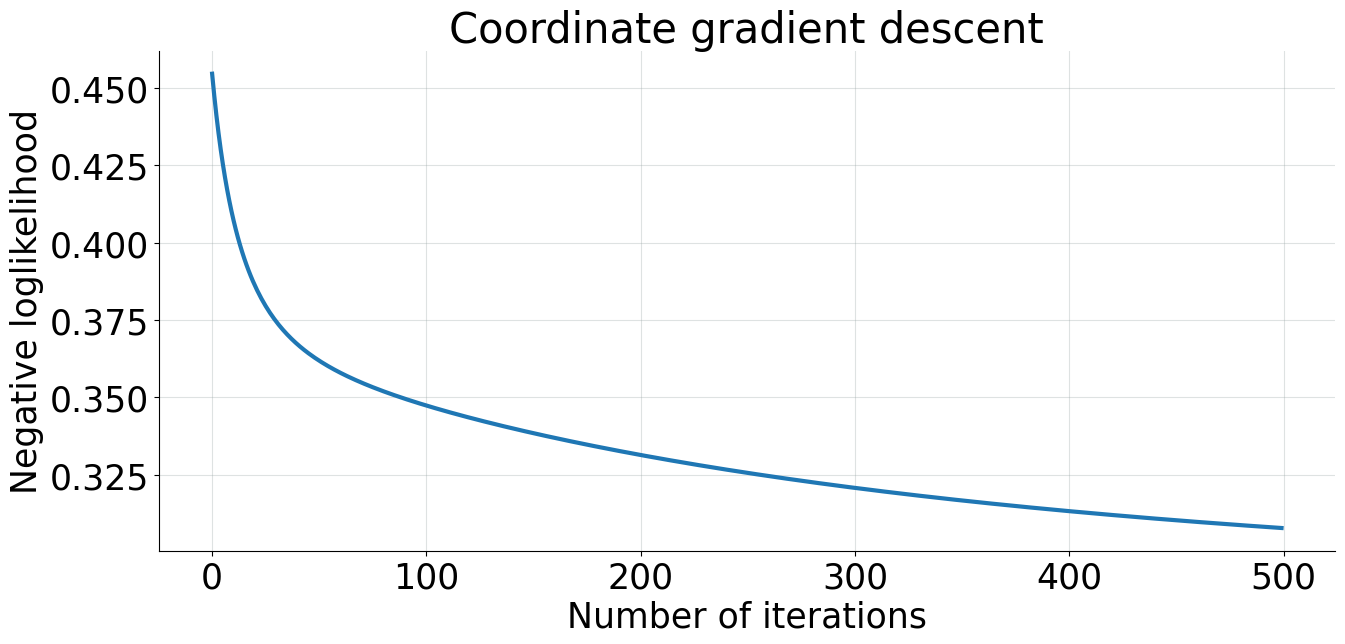

In [ ]:
step_size = 1e-1
iterations = 500
# Compute coordinate gradient descent
_, loss_history = coordinate_gd(model, w0, iterations, step_size)
# Plot loss history
plt.plot(loss_history, lw=3)
plt.title('Coordinate gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('Negative loglikelihood')
plt.tight_layout();

### <font color=darkred> Part II : Accelerated approaches </font>

Gradient descent take a long time to converge in nearly flat surface as shown in this flat optimization landscape from [5].
![](https://drive.google.com/uc?export=view&id=1etWh6TQOHmGIlxswZZyXtHv4L80renl5)


Allowing momentum to accumulate is one way to speed progress.
All gradient descent algorithms can be updated by allowing momentum to accumulate:
$v^{(k+1)} = \beta v^{
(k)} − \alpha \nabla f
(w^{(k)})$ and $w^{(k+1)} = w^{
(k)} + v^{(k+1)}$. When $\beta = 0$, we recover standard gradient descent.  The rationale is that gradient causes momentum to accumulate to improve speed of convergence.

##### <font color=darkred> Nesterov accelerated gradient descent </font>

One issue of momentum is that the steps do not slow down enough when the parameters reach the local minimum. Nesterov momentum modifies the momentum algorithm to use the gradient at the projected future position to overcome this difficulty.
``Y. Nesterov, A Method of Solving
a Convex Programming Problem
with Convergence Rate O(1/k^2),
Soviet Mathematics Doklady, vol. 27,
no. 2, pp. 543–547, 1983.``

``Input``: starting point $w^{(0)}$, learning rate $\eta_k > 0$, initial velocity $v^{(0)}=0$, momentum $\beta_k \in [0,1]$.

While not converge do    

- $v^{(k+1)} = w^{(k)} - \eta \nabla f (w^{(k)})$.

- $w^{(k+1)} = v^{(k+1)} + \beta_{k+1}( v^{(k+1)} - v^{(k)})$.

``Output``: last $w^{(n_*)}$.

Illustration of Nesterov's acceleration from [5].

![](https://drive.google.com/uc?export=view&id=1rp-Eq60V2w_WV669ZFrqLBHyviiih_rK)

###### **Implementation from scratch**

In [ ]:
def nesterov_gd(model, w, iterations, step_size, beta):
    loss_history = []
    v = w.copy()
    for k in range(iterations):
        ####
        # A completer
        v_new = w - step_size * model.grad(w)
        w = v + beta * (v_new - v)
        v = v_new
        loss_history.append(model.loss(w))
        ####
    return w, loss_history

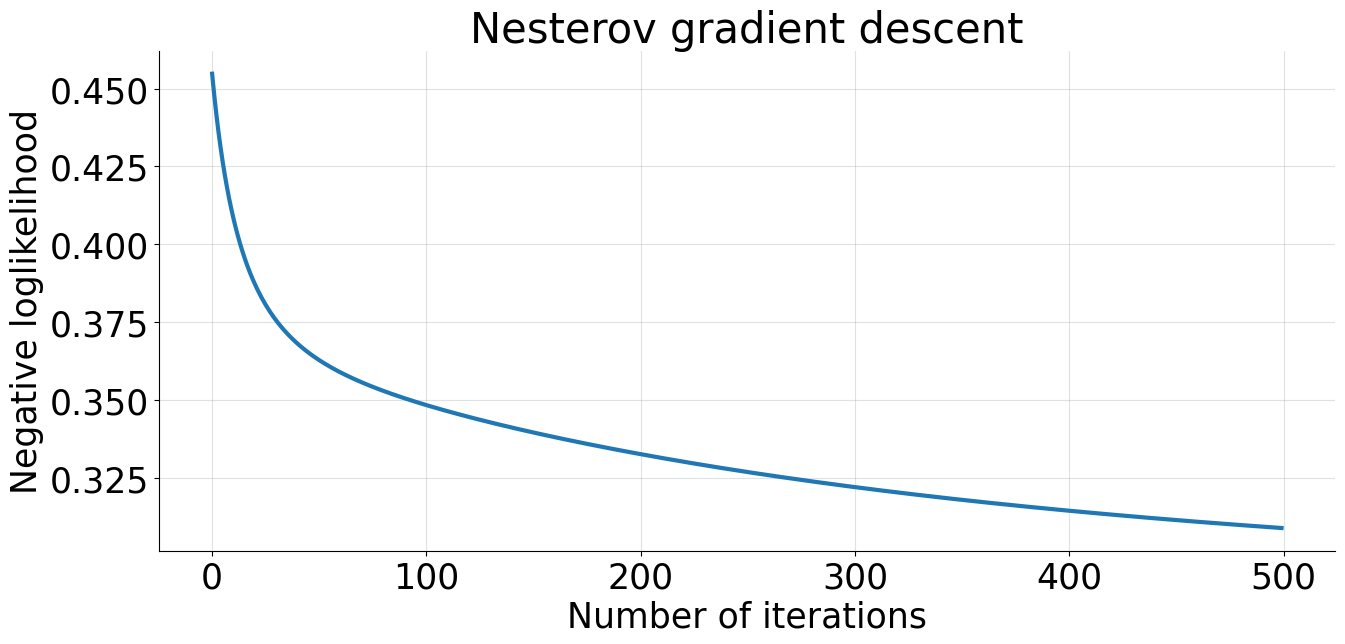

In [ ]:
beta = 0.95
step_size = 1e-1
iterations = 500
# Compute Nesterov gradient descent
w, loss_history = nesterov_gd(model, w0, iterations, step_size, beta)

# Plot loss history
plt.plot(loss_history, lw=3)
plt.title('Nesterov gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('Negative loglikelihood')
plt.tight_layout();

###### **Implementation with torch**

Simply switch
```python
optimizer = torch.optim.SGD(self.layer.parameters(), lr=lr)
```
to
```python
optimizer = torch.optim.SGD(self.layer.parameters(), lr=lr, nesterov=True)
```

###### **Convergence**

Assume that $f$ is a **$L$-smooth, convex function whose minimum is reached at $w^{\star}$**. Then, if $\beta_{k+1} = k/(k+3)$,

\begin{align*}
f(w^{(k)}) - f(w^{\star}) \leq \frac{2 \|w^{(0)} - w^{\star}\|_2^2}{\eta (k+1)^2}\,.
\end{align*}

Assume that $f$ is a **$L$-smooth, $\mu$ strongly convex function whose minimum is reached at $w^{\star}$**. Then, choosing
$$
\beta_{k} = \frac{1 - \sqrt{\mu/L}}{1 + \sqrt{\mu/L}},
$$
yields

\begin{align*}
f(w^{(k)}) - f(w^{\star}) \leq \frac{ \|w^{(0)} - w^{\star}\|_2^2}{\eta} \Big( 1 - \sqrt{\frac{\mu}{L}}\Big)^k\,.
\end{align*}


##### <font color=darkred> ADAptive GRADient and AdaDelta algorithms </font>

The adaptive subgradient method adapts the learning rate for each component of the parameter $w^{(k)}$. Adagrad weakens the influence of parameters with
 high gradients.

``Input``: starting point $w^{(0)}$, learning rate $\eta > 0$, momentum $\alpha$. 

For $k = 1, 2, \ldots$ until convergence do    

- For all $j = 1, \ldots , d$, apply the step
	\begin{equation*}
	w_j^{(k+1)} \gets w_j^{(k)} 
	- \frac{\eta}{\varepsilon + \sqrt{\sum_{\tau=1}^k (\nabla f (w^{(\tau)}))_j^2}} (\nabla f(w^{(k)}))_j
	\end{equation*}

``Output``: last $w^{(n_*)}$


``AdaDelta`` was introduced in https://arxiv.org/pdf/1212.5701.pdf (Zeiler, 2012) to reduce the sensitivity to initial conditions of AdaGrad. Indeed, if the initial gradients are large, the learning rates of AdaGrad will be low for all updates.  AdaDelta aims at avoiding the effect of a monotonically decreasing learning rate by replacing $\eta$ by an adaptive rate (exponentially decaying average of the square updates).  

###### **Implementation with torch**

Switch
```python
optimizer = torch.optim.SGD(self.layer.parameters(), lr=lr)
```
for AdaGrad to:
```python
optimizer = torch.optim.Adagrad(self.layer.parameters(), lr=lr)
```
or for AdaDelta to:
```python
optimizer = torch.optim.Adadelta(self.layer.parameters(), lr=lr)
```

##### <font color=darkred> ADAM: Adaptive moment estimation </font>

``ADAM`` was introduced in https://arxiv.org/pdf/1412.6980.pdf (Kingma et al., 2014) and **is considered as the state of the art to otpimize neural networks**, the ADAM procedure update the parameter estimate as follows. 

``Input`` $m_0 = 0$ and $v_0=0$ and choosing $\beta_1, \beta_2, \eta, \varepsilon
 \in (0,1)$, 
 
 - Compute first and second moment estimate 
$$
m_k = \beta_1 m_{k-1} + (1 - \beta_1) \nabla f (w^{(k)}) \quad  \mathrm{and} \quad v_k = \beta_2 v_{k-1} + (1 - \beta_2) (\nabla f (w^{(k)}))^2\,,
$$

- Compute the correction terms
$$
\hat{m}_k = \frac{m_k}{1 - \beta_1^k} \quad \hat{v}_k = \frac{v_k}{1 - \beta_2^k}\,,
$$

- Update the parameter estimate with
$$
w^{(k+1)} = w^{(k)} - \frac{\eta}{\sqrt{\hat{v}_k}+ \varepsilon} \hat{m}_k\,.
$$
First convergence results can be found in https://arxiv.org/pdf/1412.6980.pdf (Kingma et al., 2014) and examples where ADAM algorithm does not converge to the optimum are given in https://openreview.net/pdf?id=ryQu7f-RZ (Reddi et al., 2018). Recent analysis by https://arxiv.org/abs/1810.02263 (Barakat et al., 2018).

###### **Implementation with torch**

Switch
```python
optimizer = torch.optim.SGD(self.layer.parameters(), lr=lr)
```
to:
```python
optimizer = torch.optim.Adam(self.layer.parameters(), lr=lr)
```

In [ ]:
###
# A compléter
# Comparer la convergence de l'apprentissage du modèle de régression logistique avec SGD et ADAM
###

### <font color=darkred> Part III : Application to DPE classification>

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

plt.rcParams.update(
    {
        "font.size": 25,
        "figure.figsize": (14, 7),
        "axes.grid": True,
        "grid.color": "#93a1a1",
        "grid.alpha": 0.3,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")

Using device cpu.


In [2]:
# Download data
!wget https://gitlab.com/max.cohen/ateliers-algos/-/raw/main/dataset_DPE.csv

--2023-05-12 11:21:32--  https://gitlab.com/max.cohen/ateliers-algos/-/raw/main/dataset_DPE.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2021731 (1.9M) [text/plain]
Saving to: ‘dataset_DPE.csv’

dataset_DPE.csv     100%[===================>]   1.93M  6.38MB/s    in 0.3s    

2023-05-12 11:21:33 (6.38 MB/s) - ‘dataset_DPE.csv’ saved [2021731/2021731]



In [3]:
# Load data in a dataframe
df = pd.read_csv("dataset_DPE.csv")[:10000]
df

,Etiquette_GES,Etiquette_DPE,Année_construction,Hauteur_sous-plafond,Surface_habitable_logement,N°_région_(BAN),Conso_5_usages_é_finale
0,C,D,1945.0,2.9,220.8,27.0,37940.5
1,D,D,1948.0,2.5,36.4,11.0,8212.5
2,D,D,1948.0,2.5,49.0,53.0,9546.3
3,F,G,1947.0,2.5,47.0,11.0,18898.9
4,D,D,1948.0,2.5,49.0,53.0,9546.3
...,...,...,...,...,...,...,...
9995,B,D,2006.0,2.5,19.1,84.0,1971.9
9996,D,D,1830.0,2.5,109.0,28.0,5823.6
9997,D,G,1947.0,2.6,18.8,11.0,7675.7
9998,B,D,1994.0,2.5,16.5,11.0,1629.5


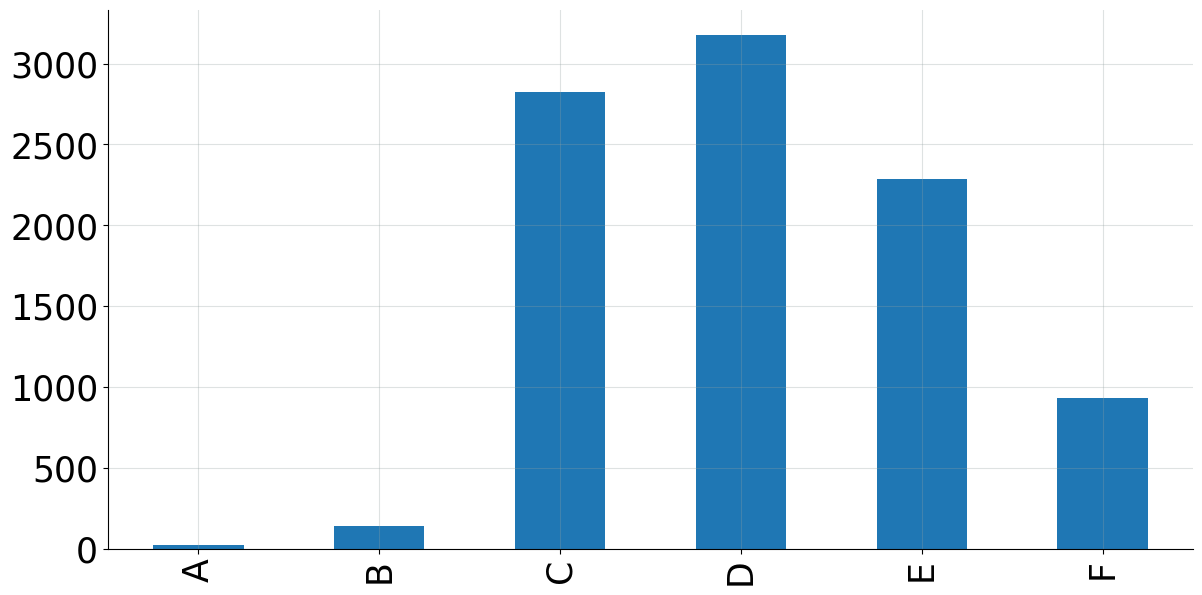

In [4]:
# Visualize the DPE notation distribution in the dataset
df["Etiquette_DPE"].value_counts().loc[['A', 'B', 'C', 'D', 'E', 'F']].plot(kind="bar");

In [5]:
class DatasetDPE(Dataset):
    """Torch Dataset for preprocessing and accessing the dataframe.

    In the ``__init__`` function, we preprocess the dataframe by
     - converting DPE notations to numeric classes
     - storing input variables and targets to tensors
     - normalizing the input tensor

    The two additionnal ``__len__`` and ``__getitem__`` functions allows for
    accessing samples of the dataset, and are used by the Torch Dataloaders.
    """
    def __init__(self, df: pd.DataFrame):
        super().__init__()
        # Use a numeric classification for DPE (i.e. A, B, C -> 0, 1, 2)
        df["DPE_class"] = df["Etiquette_DPE"].apply(
            lambda etiquette: ord(etiquette)-65
        )
        # Convert columns to input tensors X and target y
        self.X = torch.tensor(df[[
            'Année_construction',
            'Hauteur_sous-plafond',
            'N°_région_(BAN)',
            'Surface_habitable_logement',
            'Conso_5_usages_é_finale',
        ]].values, dtype=torch.float32)
        self.y = torch.tensor(df["DPE_class"].values, dtype=torch.long)
        # Normalize input data
        self.X = (self.X - self.X.min(axis=0)[0]) / (self.X.max(axis=0)[0] - self.X.min(axis=0)[0])
        
    def __len__(self) -> int:
        return len(self.X)
    
    def __getitem__(self, idx: int) -> tuple[torch.tensor]:
        return (self.X[idx], self.y[idx])
  
# Instantiate the dataset
dataset = DatasetDPE(df)
# Setup a dataloader, specify the batch size
dataloader = DataLoader(dataset, batch_size=16, num_workers=2, shuffle=True)

##### <font color=darkred> Model: Multi layer perceptron (feed forward neural network) </font>

The aim is to predict the class of each data. **Softmax regression** provides a model for the probability that an input $x$ is associated with each class.  

In the case where there are $K$ classes, we write, for all $1\leq k \leq K$:
$$
\mathbb{P}(Y=k|X) = \frac{\exp\left(w_k^\top X\right)}{\sum_{j=1}^K\exp\left(w_j^\top X\right)}
$$
where $\omega_j$, $1\leq j\leq K$, are the unknown parameter to be estimated.
Stochastic gradient descent and its accelerated versions can be used to learn these parameters using small batches of data.   

To illustrate gradient-based optimization procedures we propose **dense neural networks** to introduce non linearities. 
The Multi-layer Perceptron (MLP) or Feed Forward Neural Network (FFNN) uses $L$ layers to produce the output. Define all layers as follows.
\begin{align*}
h_{\theta}^0(X) &= X\,,\\
z_{\theta}^k(X)  &= b^k + W^kh_{\theta}^{k-1}(X)\quad \mathrm{for\;all\;} 1\leqslant k\leqslant L\,,\\
h_{\theta}^k(X)  &= \varphi_k(z_{\theta}^{k}(X))\quad \mathrm{for\;all\;}1\leqslant k\leqslant L\,,
\end{align*}
where $b^1\in\mathbb{R}^{d_1}$, $W^1\in\mathbb{R}^{d_1\times d}$ and for all $2\leqslant k\leqslant L$, $b^k\in\mathbb{R}^{d_k}$, $W^k\in\mathbb{R}^{d_k\times d_{k-1}}$. For all $1\leqslant k\leqslant L$, $\varphi_k: \mathbb{R}^{d_k} \to \mathbb{R}^{d_k}$ is a nonlinear activation function. Let $\theta = \{b^1,W^1,\ldots,b^L,W^L\}$ be the unknown parameters of the MLP and $f_{\theta}(x) = h_{\theta}^L(x)$ be the output layer of the MLP. As there is no modelling assumptions anymore, virtually any activation functions $\varphi^m$, $1\leqslant m\leqslant L-1$ may be used. In this section, it is assumed that these intermediate activation functions apply elementwise and, with a minor abuse of notations, we write for all $1\leqslant m\leqslant L-1$ and all $z\in\mathbb{R}^{d_m}$,
$$
\varphi^m(z) = (\varphi^m(z_1),\ldots, \varphi^m(z_{d_m}))\,,
$$
with $\varphi^m: \mathbb{R}\to \mathbb{R}$ the seleced scalar activation function. The rectified linear unit (RELU) activation function $x \mapsto \mathrm{max}(0,x)$ and its extensions are the default recommendation in modern implementations.

In our case,  The output $h_{\theta}^L(x)$ is the estimate of the probability that the class is  $k$ for all $1\leqslant k\leqslant M$, given the input $x$. The common choice in this case is the softmax function.

Illustration of a layer (from IP Paris M2 lecture notes).
![](https://drive.google.com/uc?export=view&id=1fT1zNeMxLsoxRKDIKGq4zGYhn8FP-Uk7)


Illustration of dense network (from IP Paris M2 lecture notes).
![](https://drive.google.com/uc?export=view&id=1rZCDI4Yvb5vEj1VygPPxc3_kVUgE0-vJ)


In [6]:
# We define a model with a hidden state and a ReLU non linearity
num_hidden = 16
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=5, out_features=num_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=num_hidden, out_features=len(df["DPE_class"].unique())),
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

##### <font color=darkred> Model training using gradient descent </font>

In [7]:
epochs = 50
hist_loss = []
# Iterate through the epochs
for _ in tqdm.tqdm(range(epochs)):
    running_loss = 0
    # Iterate through each training sample in the dataset
    for X, y in dataloader:
        # Move X and y to the device
        X = X.to(device)
        y = y.to(device)
        # Compute the prediction error
        loss = loss_function(model(X), y)
        # Backpropagate the error
        optimizer.zero_grad()
        loss.backward()
        # Run one gradient step
        optimizer.step()
        # Log the current error
        running_loss += loss.item()
    hist_loss.append(running_loss / len(dataloader))

100%|██████████| 50/50 [01:33<00:00,  1.88s/it]


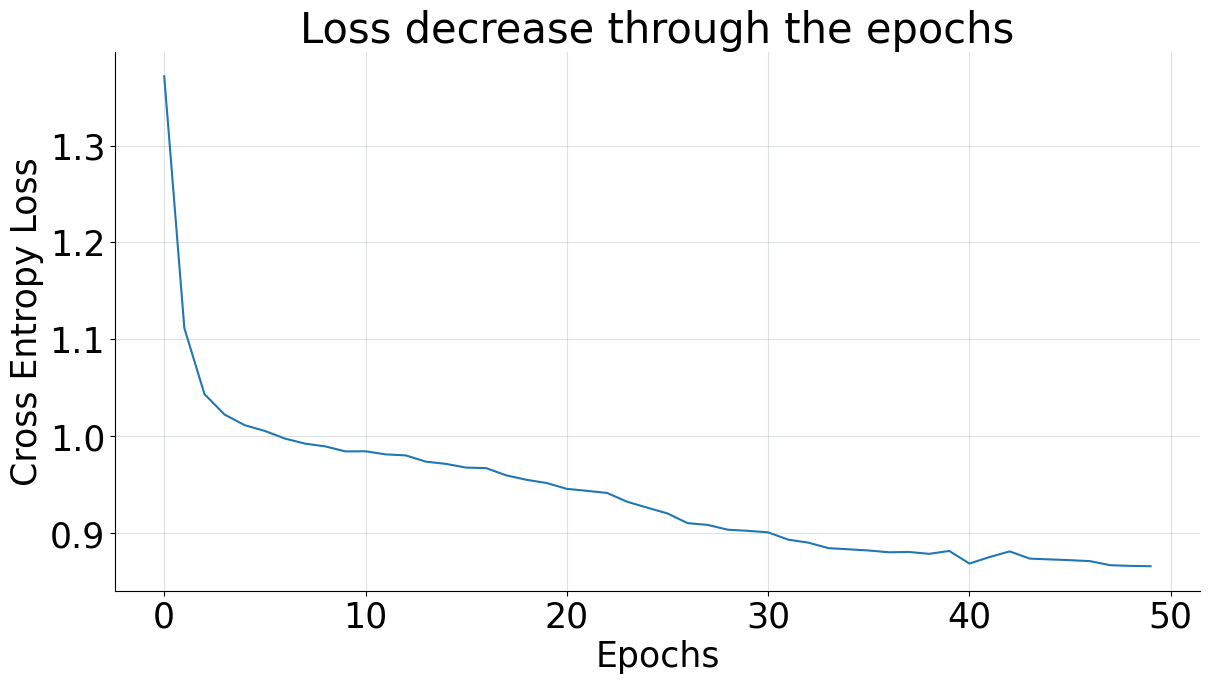

In [8]:
plt.title("Loss decrease through the epochs")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.plot(hist_loss);

In [9]:
# Compute the accuracy on the entire dataset
accuracy = 0
for X, y in dataloader:
    # Move X and y to device
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        prediction = torch.nn.functional.softmax(
            model(X), dim=-1
        ).argmax(dim=-1)
        accuracy += (prediction == y).sum().item()
print(f"Accuracy: {accuracy / len(dataset):.2f}")

Accuracy: 0.68


In [ ]:
###
# A compléter
# 1 - Créer un modèle avec deux couches intermédiares 
# 2 - Comparer la convergence de l'apprentissage du modèle avec SGD et ADAM
###